# SHAP (Shapley Additive exPlanations)

## 초기 설정

In [1]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
import shap

from matplotlib import pyplot as plt
import pandas as pd

## Classification

### 데이터 로드 및 전처리

In [22]:
# scikit-learn의 유방암 데이터 셋 사용
breast_cancer_data = load_breast_cancer()

X = pd.DataFrame(breast_cancer_data.data)
X.columns = breast_cancer_data.feature_names
y = pd.DataFrame(breast_cancer_data.target)

In [3]:
# 학습/테스트 데이터 분류 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [4]:
# XGB 분류 모델 생성
classify_xgb = XGBClassifier(n_estimators=100, random_state=3)
classify_xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:02:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
print(f'Train set accuracy: {classify_xgb.score(X_train, y_train):.3f}')
print(f'Test set accuracy: {classify_xgb.score(X_test, y_test):.3f}')

Train set accuracy: 1.000
Test set accuracy: 0.965


### Explaining

In [29]:
# SHAP의 출력을 위해 실행
shap.initjs()

In [23]:
explainer = shap.Explainer(classify_xgb)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


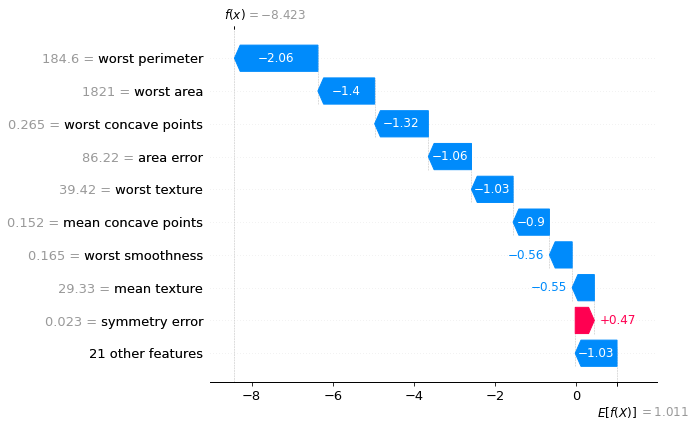

In [27]:
shap.plots.waterfall(shap_values[0])

In [30]:
shap.plots.force(shap_values[0])

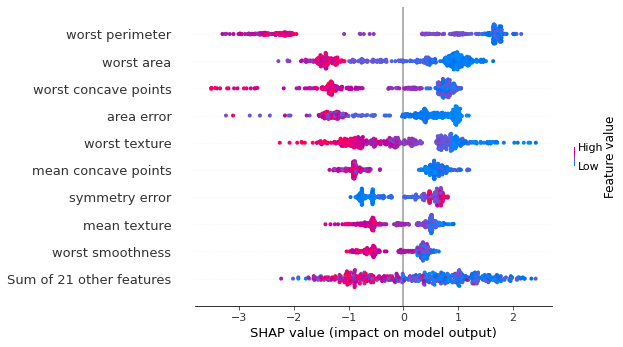

In [32]:
shap.plots.beeswarm(shap_values)

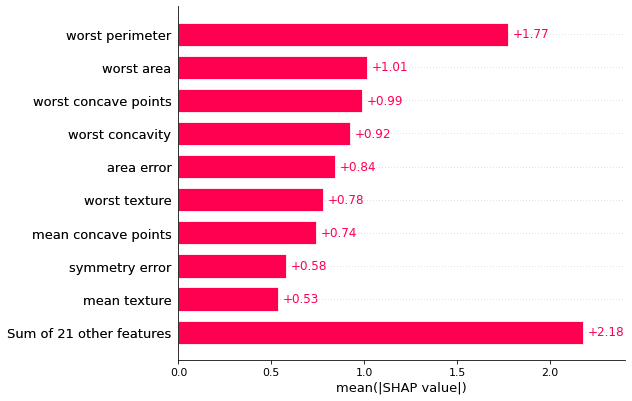

In [43]:
shap.plots.bar(shap_values)

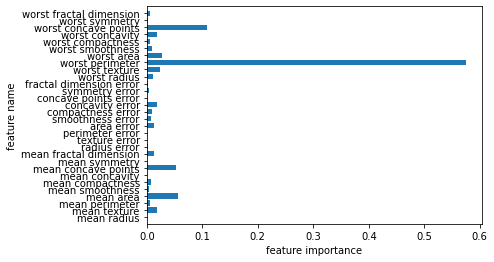

In [44]:
# 결정 트리의 특성 중요도를 시각화
def plot_feature_importance(data, model):
    n_features = len(data.feature_names)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), data.feature_names)
    plt.xlabel('feature importance')
    plt.ylabel('feature name')
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importance(breast_cancer_data, classify_xgb)

- 두 explaining에서 worst periment가 가장 중요한 feature로 선택됨 
- 다른 features도 tree의 importance와 유사함
- symmetry error의 경우 tree에서는 낮게 평가했으나 shap에서는 높게 평가함 (tree의 경우 유사한 특징을 갖는 다른 feature때문에 중요도가 제대로 체크되지 않았을 수 있음)

## Regression

### 데이터 로드 및 전처리

In [46]:
# scikit-learn의 당뇨병 데이터
# data의 경우 나이, 성별 등 환자의 특성
# target의 경우 baseline을 기준으로 한 질병의 진행 정도
diabetes_data = load_diabetes()

X = pd.DataFrame(diabetes_data.data)
X.columns = diabetes_data.feature_names
y = pd.DataFrame(diabetes_data.target)

In [47]:
# 학습/테스트 데이터 분류 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

In [48]:
# XGB 회귀 모델 생성
regression_xgb = XGBRegressor(n_estimators=100, random_state=3)
regression_xgb.fit(X_train, y_train)

# 학습/테스트 데이터에 대해 성능 평가
print(f'Train set accuracy: {regression_xgb.score(X_train, y_train):.3f}')
print(f'Test set accuracy: {regression_xgb.score(X_test, y_test):.3f}')

Train set accuracy: 1.000
Test set accuracy: 0.329


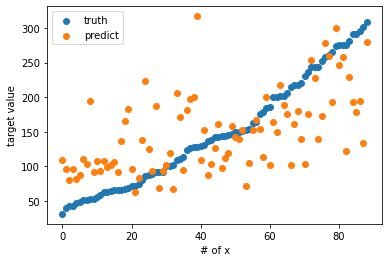

In [49]:
# 모델 예측 결과 확인을 위해 테스트의 타겟/예측 데이터 정렬
pred_test = regression_xgb.predict(X_test)
test_sort_indices = y_test.reshape(-1).argsort()
y_test_sort = y_test[test_sort_indices]
pred_test_sort = pred_test[test_sort_indices]

# 테스트 데이터에 대한 타겟/예측 값 확인
plt.scatter(range(len(y_test)), y_test_sort, label='truth')
plt.scatter(range(len(y_test)), pred_test_sort, label='predict')
plt.xlabel('# of x')
plt.ylabel('target value')
plt.legend()
plt.show()

### Explaining

In [50]:
explainer = shap.Explainer(regression_xgb)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


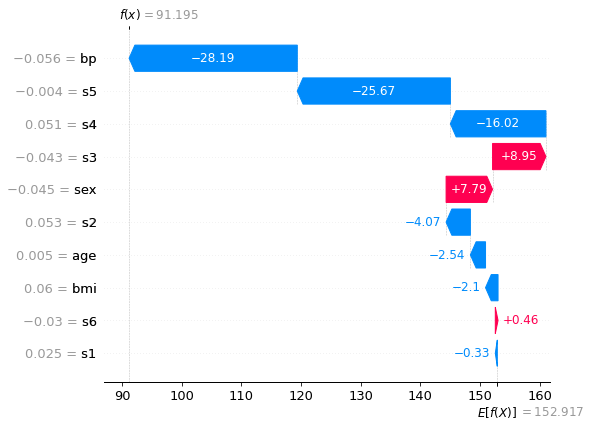

In [51]:
shap.plots.waterfall(shap_values[0])

In [52]:
shap.plots.force(shap_values[0])

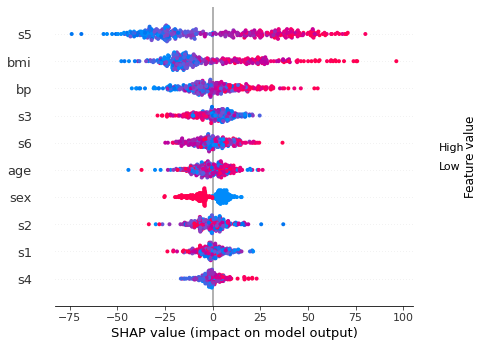

In [53]:
shap.plots.beeswarm(shap_values)

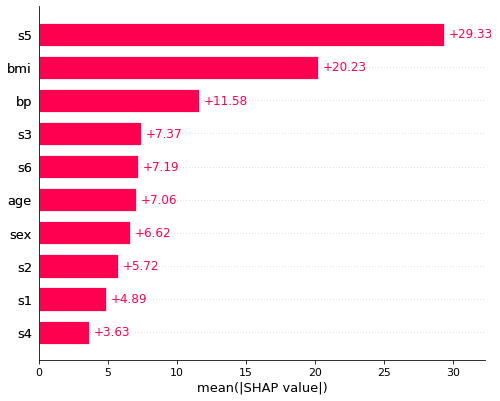

In [54]:
shap.plots.bar(shap_values)

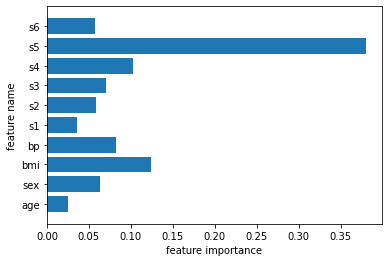

In [55]:
plot_feature_importance(diabetes_data, regression_xgb)

- s4의 경우 LIME에서와 동일하게 tree에서는 높은 중요도를 가졌으나 shap에서는 낮은 중요도를 보임